# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import lightgbm as lgb
import random

In [2]:
# garbage collection
import gc
gc.enable()

In [3]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [5]:
# data name (used for saving files too)
data_name = "data_v4_0_60"

In [6]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [7]:
# data name (used for saving files too)
data_name = "data_v4_0_60_full_r27_wlp_lm_bm"

In [8]:
# drop high recency from train
data = data[(data.Week == 121) | (data.Recency2 < 27)]
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]
data.shape

(21895593, 45)

# 3. PREPARATIONS

### ADD MORE FEATURES

In [9]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1
print(data.shape)

(21895593, 45)


In [10]:
### RF Ratios

#data["R12_ratio"] = data.Recency1 / data.Recency2
#data["R13_ratio"] = data.Recency1 / data.Recency3
#data["R14_ratio"] = data.Recency1 / data.Recency4
#data["R56_ratio"] = data.Recency5 / data.Recency6

#data["F12_ratio"] = data.Frequency1 / data.Frequency2
#data["F13_ratio"] = data.Frequency1 / data.Frequency3
#data["F14_ratio"] = data.Frequency1 / data.Frequency4
#data["F56_ratio"] = data.Frequency5 / data.Frequency6

#data.shape

In [11]:
# add last week sum (CUST)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "Week", "LastWeekCustSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week sum (BOND)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["IsinIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "Week", "LastWeekBondSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "Week"])
print(data.shape)

(21895593, 46)
(21895593, 47)


In [12]:
### ADD PRICE AND NOTIONAL

tmp = pd.read_csv("../data/prepared/price_notional.csv", compression = "gzip")

# add last week price sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.Price.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustPriceSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week notional sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.NotionalEUR.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustNotionalSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

(21895593, 48)
(21895593, 49)


In [13]:
### ADD CUSTOMER INDICATORS

#cust  = pd.read_csv("../data/raw/Customer.csv")
#cust.head()

# create dummies for customers
#cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Subsector)], axis = 1)

# merge customer dummies
#data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")
#print(data.shape)

In [14]:
### ADD BOND FEATURES [V1]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", "t", "timeOnMarket", "percentoflifeleft"]], how = "left", on = "IsinIdx")
#print(data.shape)

In [15]:
### ADD NEW BOND FEATURES [V2]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat2_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'ymeansq', 'ymeancube', 'zmeansq', 'zmeancube',
#                             'years_tomaturity', 'count', 'ratingspread', 'ratingZspread']], 
#                  how = "left", on = "IsinIdx")
#print(data.shape)

In [16]:
### ADD BOND FEATURES [V3]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat3_AK")
#bond_stat.head()

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'predyield', 'predprice']], how = "left", on = "IsinIdx")
#print(data.shape)

In [17]:
### BOND-SPECIFIC FINANCIAL INDICATORS

#bond  = pd.read_csv("../data/raw/Isin.csv")

# create bond dummies
#bond_dummies = pd.concat([bond.IsinIdx,
#                          pd.get_dummies(bond.IndustrySector), 
#                          pd.get_dummies(bond.Region),
#                          pd.get_dummies(bond.MarketIssue), 
#                          pd.get_dummies(bond.CouponType)], axis = 1)

# merge bond dummies
#data = data.merge(bond_dummies, on = "IsinIdx", how = "left")
#print(data.shape)

In [18]:
### ADD NEW NIKITA FEATURES

# import data
#cust    = pd.read_csv("../data/prepared/cust_nik.csv",   compression = "gzip")
#bond    = pd.read_csv("../data/prepared/bond_nik.csv",   compression = "gzip")
#market  = pd.read_csv("../data/prepared/market_nik.csv", compression = "gzip")

#cust = cust[["CustomerIdx", "Region"]]
#bond = bond[["IsinIdx", "ActualMaturityDateKey", "IssueDateKey"]]

# merge data
#print(data.shape)
#data = data.merge(cust, on = "CustomerIdx", how = "left")
#print(data.shape)
#data = data.merge(bond, on = "IsinIdx", how = "left")
#print(data.shape)
#data = data.merge(market, on = ["IsinIdx", "Week"], how = "left")
#print(data.shape)

# compute day differences
#data["ActualMaturityDateKey"] = data["ActualMaturityDateKey"] - data["Week"]
#data["IssueDateKey"]          = data["IssueDateKey"] - data["Week"]

In [19]:
### ADD LAST MONTH SUMS

# merge month number
tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# add last month mean (CUST)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["CustomerIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "CumMonth", "LastMonthCustSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "CumMonth"])
print(data.shape)

# add last month mean (BOND)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["IsinIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "CumMonth", "LastMonthBondSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "CumMonth"])
print(data.shape)

# drop month
del data["CumMonth"]

(21895593, 51)
(21895593, 52)


In [20]:
### ADD BOND MATURITY DATA

# import
bond = pd.read_csv("../data/prepared/data_bond_v1.csv", compression = "gzip")
bond = bond[['IsinIdx', 'MaturityWeek', 'IssueWeek']]

# merge
data = data.merge(bond, on = "IsinIdx", how = "left")

# compute week differences
data["MaturityWeek"]    = data.MaturityWeek - data.Week
data["IssueWeek"]       = data.Week - data.IssueWeek
data["MaturityPercent"] = (data.Week - data.IssueWeek) / (data.MaturityWeek - data.IssueWeek)
print(data.shape)

(21895593, 54)


### CHECKS AND PREPARATIONS

In [21]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (21895593, 54)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta,LastWeekCustSum,LastWeekBondSum,LastWeekCustPriceSum,LastWeekCustNotionalSum,LastMonthCustSum,LastMonthBondSum,MaturityWeek,IssueWeek,MaturityPercent
0,NaN,0,16471,Buy,0.0,73,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.013889,0.013889,0.111111,0.236111,0.305556,0.597222,0,1,11,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414,0.0,0.0,104.120,2332048.0,0.0,0.0,105,155,1.640000
1,NaN,0,16471,Buy,0.0,73,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.013889,0.013889,0.111111,0.236111,0.305556,0.597222,0,1,12,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414,0.0,0.0,104.120,2332048.0,0.0,0.0,105,155,1.640000
2,NaN,0,16471,Buy,0.0,74,2.0,2.0,2.0,1.0,1.0,1.0,1,0,0.013699,0.013699,0.109589,0.246575,0.315068,0.602740,0,1,11,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414,2.0,2.0,100.200,5632544.0,0.0,0.0,104,156,1.576923
3,NaN,0,16471,Buy,0.0,75,3.0,3.0,3.0,2.0,2.0,1.0,1,0,0.013514,0.013514,0.108108,0.243243,0.310811,0.608108,0,1,11,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414,0.0,0.0,NaN,NaN,2.0,2.0,103,157,1.518519
4,NaN,0,16471,Buy,0.0,76,4.0,4.0,1.0,1.0,3.0,2.0,1,0,0.013333,0.013333,0.120000,0.253333,0.306667,0.600000,0,1,11,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414,0.0,0.0,104.875,6029477.0,2.0,2.0,102,158,1.464286


In [22]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx              21410835
CustomerInterest             484758
MeanPrice                   1646381
StdPrice                    1647042
MeanYield                   1646381
StdYield                    1647042
MeanZScore                  1646381
StdZScore                   1647042
YieldMarktDelta             1646381
ZScoreMarktDelta            1646381
LastWeekCustSum              287569
LastWeekBondSum              315049
LastWeekCustPriceSum        1128015
LastWeekCustNotionalSum     1128015
LastMonthCustSum             290404
LastMonthBondSum             398147
MaturityPercent                   7
dtype: int64

In [23]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest",
                     "Frequecny1isLowerFrequency2", "Frequecny2isLowerFrequency4"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

47

In [24]:
### DATA PARTITIONING

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

In [25]:
# check NA in test
nas = test.isnull().sum()
nas[nas > 0]

CustomerInterest           484758
MeanPrice                    5414
StdPrice                     5476
MeanYield                    5414
StdYield                     5476
MeanZScore                   5414
StdZScore                    5476
YieldMarktDelta              5414
ZScoreMarktDelta             5414
LastWeekCustSum                50
LastWeekBondSum               352
LastWeekCustPriceSum        24032
LastWeekCustNotionalSum     24032
LastMonthCustSum              158
LastMonthBondSum             3790
dtype: int64

# 4. MODELING - STAGE 1

In [26]:
### PARAMETERS

# parallel settings
cores = 20

# learner settings
metric   = "auc"
verbose  = 250
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [27]:
# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train), 
                          (X_valid[features], y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  


##### RESULTS (K = 42 - v4wlp)

# full data:     0.847355 ()
# full - r27:    0.786895 (0.79244 LB)
# under data:    0.847501 (0.79385 LB)
# under - r27:   0.787625 (0.79269 LB)


##### RESULTS (K = 44 - v4wlpm_lm, added last month sums)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.847455 ()
# under - r27:   0.788729 ()


##### RESULTS (K = 47 - v4wlpm_lm_bm, added bond maturity features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850085 (0.79856 LB)
# under - r27:   0.791607 ()


##### RESULTS (K = 48 - v4wlpm_lm_bm_wc, added weekly currency trend)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0. ()
# under - r27:   0.791504 ()


##### RESULTS (K = 57 - v4wlpm_lm_bm_wm, added weekly macro features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850068 ()
# under - r27:   0.786000 ()

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.787546	valid_1's auc: 0.77564
[500]	valid_0's auc: 0.792441	valid_1's auc: 0.780427
[750]	valid_0's auc: 0.796224	valid_1's auc: 0.783336
[1000]	valid_0's auc: 0.798997	valid_1's auc: 0.78553
[1250]	valid_0's auc: 0.801207	valid_1's auc: 0.786584
[1500]	valid_0's auc: 0.803233	valid_1's auc: 0.787727
[1750]	valid_0's auc: 0.805034	valid_1's auc: 0.788555
[2000]	valid_0's auc: 0.806547	valid_1's auc: 0.789413
[2250]	valid_0's auc: 0.807894	valid_1's auc: 0.789811
[2500]	valid_0's auc: 0.809116	valid_1's auc: 0.790252
[2750]	valid_0's auc: 0.810307	valid_1's auc: 0.790781
[3000]	valid_0's auc: 0.811411	valid_1's auc: 0.791141
[3250]	valid_0's auc: 0.812372	valid_1's auc: 0.791464
[3500]	valid_0's auc: 0.813279	valid_1's auc: 0.791717
[3750]	valid_0's auc: 0.81411	valid_1's auc: 0.791869
[4000]	valid_0's auc: 0.814958	valid_1's auc: 0.792062
[4250]	valid_0's auc: 0.815722	valid_1's auc: 0.792214
[4500]	v

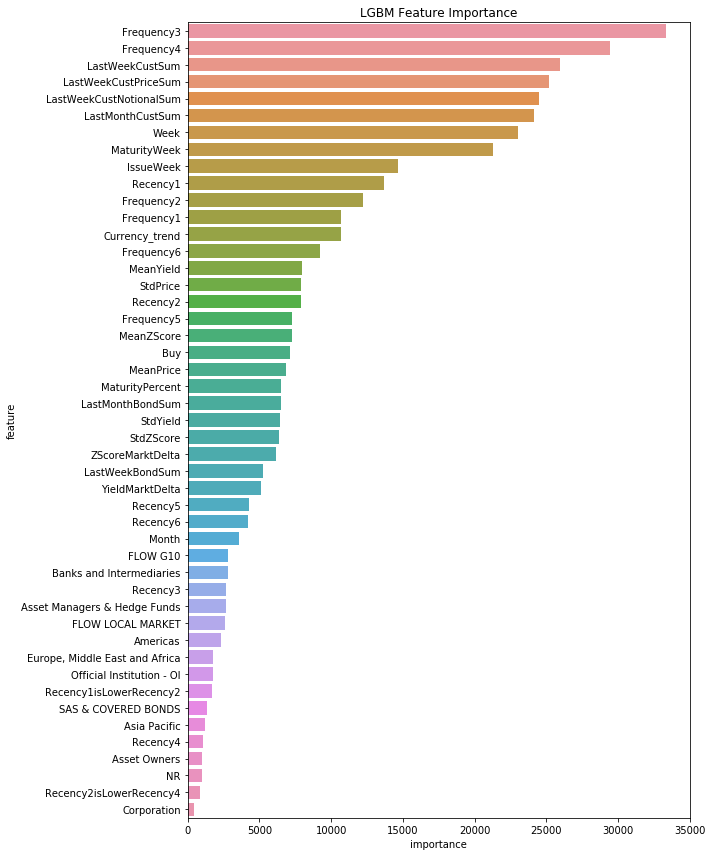

In [28]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 12))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# save plot as pdf
#plt.savefig("../var_importance.pdf")

In [29]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = gbm.predict_proba(X_valid[features], num_iteration = num_iters)[:, 1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# check rank correlation with the best submission
best = pd.read_csv("../pred_valid/auc786895_data_v4_0_60_full_r27_wlp_lgb.csv")
best.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest', 'TARGET_best']
best = best.merge(pred_valid[["CustomerIdx", "IsinIdx", "BuySell", "TARGET"]], 
                  how = "right", on = ["CustomerIdx", "IsinIdx", "BuySell"])
print(spearmanr(best.TARGET, best.TARGET_best))

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc786895_data_v4_0_60_full_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
print(spearmanr(best["TARGET"], best.CustomerInterest))

# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_1stage.csv", 
            index = False, float_format = "%.8f")

SpearmanrResult(correlation=0.9716113535021297, pvalue=0.0)
SpearmanrResult(correlation=0.9700161244807995, pvalue=0.0)


# 5. MODELING - STAGE 2

In [30]:
# keep top features
#top = 100
#features = list(importance["feature"][0:np.min([top, len(features)])])

In [31]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

In [ ]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train)], 
              eval_metric = metric, verbose = 250)

[250]	valid_0's auc: 0.787321
[500]	valid_0's auc: 0.792131
[750]	valid_0's auc: 0.795974
[1000]	valid_0's auc: 0.798647
[1250]	valid_0's auc: 0.800867
[1500]	valid_0's auc: 0.802849
[1750]	valid_0's auc: 0.804693
[2000]	valid_0's auc: 0.806262
[2250]	valid_0's auc: 0.807621
[2500]	valid_0's auc: 0.808763
[2750]	valid_0's auc: 0.809892
[3000]	valid_0's auc: 0.810957
[3250]	valid_0's auc: 0.811912


In [ ]:
# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

In [ ]:
# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc786895_data_v4_0_60_full_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
spearmanr(best["TARGET"], best.CustomerInterest)

In [ ]:
# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_2stage.csv", 
            index = False, float_format = "%.8f")